# Library import and data preprocessing

**Importing the libraries**

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

**Data Transformation**

Defines a set of transformations to be applied to images for data augmentation and normalization during the training, validation, and testing phases.

In [ ]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Importing the annotated and labeled dataset

In [ ]:
# Define the data directory
data_dir = '/content/drive/MyDrive/ML_PROJECT/dataset'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
#image_datasets

**Dataloader**

for loading and batching image datasets and retrieves the dataset sizes and class names.

In [ ]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 5704, 'val': 923, 'test': 185}


['cocci', 'healthy', 'ncd', 'salmo']

# Classification Model

**Resnet50**

The pretrained model used for prediction by freezing all the layer except the final layer(classification layer) allowing model to update weight of the classification layer according to the given dataset.


In [ ]:
# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


**Training the model**

Using transfer learning on resnet50 model to use it for classification of poultry disease given the fecal images



In [ ]:
# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 0.8120 Acc: 0.7200
val Loss: 0.2808 Acc: 0.9112
train Loss: 0.6229 Acc: 0.7740
val Loss: 0.3430 Acc: 0.8754
train Loss: 0.6268 Acc: 0.7779
val Loss: 0.1989 Acc: 0.9317
train Loss: 0.5769 Acc: 0.7959
val Loss: 0.1792 Acc: 0.9328
train Loss: 0.6109 Acc: 0.7877
val Loss: 0.2757 Acc: 0.9122
train Loss: 0.5659 Acc: 0.7998
val Loss: 0.1547 Acc: 0.9491
train Loss: 0.5641 Acc: 0.8003
val Loss: 0.1608 Acc: 0.9491
train Loss: 0.5716 Acc: 0.8054
val Loss: 0.1585 Acc: 0.9480
train Loss: 0.5372 Acc: 0.8115
val Loss: 0.1463 Acc: 0.9588
train Loss: 0.5467 Acc: 0.8084
val Loss: 0.1912 Acc: 0.9350
train Loss: 0.5522 Acc: 0.8093
val Loss: 0.1416 Acc: 0.9512
train Loss: 0.5480 Acc: 0.8079
val Loss: 0.1646 Acc: 0.9372
train Loss: 0.5369 Acc: 0.8082
val Loss: 0.1209 Acc: 0.9588
train Loss: 0.5508 Acc: 0.8112
val Loss: 0.2042 Acc: 0.9198
train Loss: 0.5549 Acc: 0.8084
val Loss: 0.1547 Acc: 0.9447
Training complete!


**Model Evaluation**

Evaluating the model's performance on the test dataset to achieve the test accuracy > 92%

In [ ]:
# Set model to evaluation mode
model.eval()

# Initialize test accuracy and loss
test_loss = 0.0
correct_predictions = 0

# Turn off gradients for validation (saves memory and computations)
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Calculate accuracy
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        test_loss += loss.item() * inputs.size(0)

# Calculate average loss and accuracy
test_loss = test_loss / dataset_sizes['test']
test_acc = correct_predictions.double() / dataset_sizes['test']

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 0.1790, Test Accuracy: 0.9297


In [ ]:
torch.save(model.state_dict(), '/content/disease_classification_model.pth')

#An utility function
This is an utility function to have prediction using the trained model and a given image using *image_path* *italicised text*

In [ ]:
from PIL import Image

# Load the saved ResNet-50 model
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('/content/disease_classification_model.pth'))
model.eval()

# Create a new ResNet-50 model with the correct final layer
new_model = models.resnet50(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]

<ipython-input-35-83da48fbaed7>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/disease_classification_model.pth'))


**Preprocessing**

the image is being preprocessed similary as of train data before being fed up for the prediction

In [ ]:
# Load and preprocess the unseen image
image_path = '/content/drive/MyDrive/ML_PROJECT/dataset/val/salmo/salmo.1801.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [ ]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['cocci', 'healthy', 'ncd', 'salmo']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: salmo


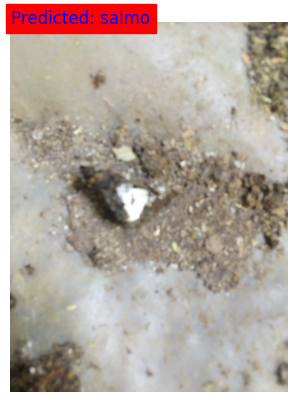

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='blue', backgroundcolor='red')
plt.show()